In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv("../Merging/Merged_Data.csv")
print(data.columns)
data.head(5)

Index(['period', 'plantCode', 'plantName', 'fuel2002', 'fuelTypeDescription',
       'state', 'stateDescription', 'primeMover', 'total-consumption',
       'total-consumption-units', 'total-consumption-btu', 'generation',
       'gross-generation', 'consumption-for-eg', 'consumption-for-eg-units',
       'consumption-for-eg-btu', 'average-heat-content',
       'average-heat-content-units', 'total-consumption-btu-units',
       'generation-units', 'gross-generation-units',
       'consumption-for-eg-btu-units', 'X', 'Y', 'FID', 'OBJECTID',
       'Plant_Code', 'Plant_Name', 'Utility_ID', 'Utility_Na', 'sector_nam',
       'Street_Add', 'City', 'County', 'State', 'Zip', 'PrimSource',
       'source_des', 'tech_desc', 'Install_MW', 'Total_MW', 'Bat_MW', 'Bio_MW',
       'Coal_MW', 'Geo_MW', 'Hydro_MW', 'HydroPS_MW', 'NG_MW', 'Nuclear_MW',
       'Crude_MW', 'Solar_MW', 'Wind_MW', 'Other_MW', 'Source', 'Period',
       'Longitude', 'Latitude', 'LATITUDE', 'LONGITUDE', 'DATE', 'ELEVATION',


,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,total-consumption,total-consumption-units,...,WDSP,MXSPD,GUST,MAX,MIN,PRCP,SNDP,TEMPEXT_BASE40,TEMPEXT_BASE45,TEMPEXT_BASE50
0,2020-01-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,84432,MMBtu per Mcf,...,4.396667,10.500000,0.0,71.056667,58.350000,0.0,0.0,23.723333,18.723333,14.123333
1,2020-12-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,11343,MMBtu per Mcf,...,4.954839,10.467742,0.0,66.354839,50.877419,0.0,0.0,17.293548,12.487097,8.706452
2,2023-08-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,109965,MMBtu per Mcf,...,4.161290,8.861290,0.0,92.887097,81.596774,0.0,0.0,46.403226,41.403226,36.403226
3,2023-04-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,12548,MMBtu per Mcf,...,5.300000,10.276667,0.0,79.033333,67.726667,0.0,0.0,32.903333,27.903333,22.903333
4,2023-02-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,96587,MMBtu per Mcf,...,5.007143,9.975000,0.0,75.085714,59.167857,0.0,0.0,25.867857,20.867857,15.867857


In [3]:

data['period'] = pd.to_datetime(data['period'])
data.sort_values(by='period', inplace=True)
plant_codes = data['plantCode'].unique()
data = data[data['period'] >= '2019-01-01']

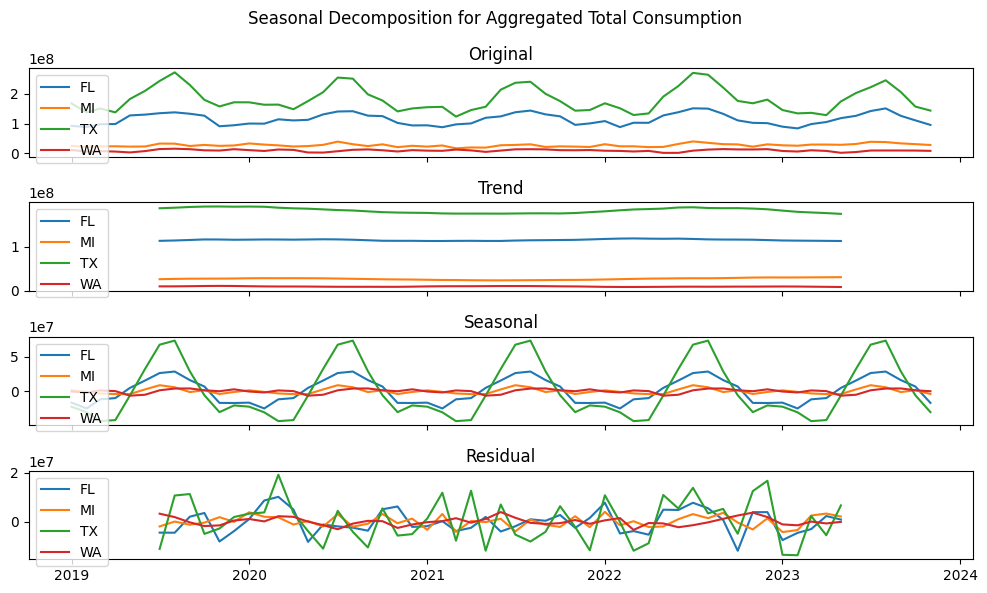

In [4]:
# Convert 'period' column to datetime
data['period'] = pd.to_datetime(data['period'])

# Group by 'period' and 'state', then sum 'total-consumption'
aggregated_data = data.groupby(['period', 'state'])['total-consumption'].sum().unstack().fillna(0)

# Perform seasonal decomposition on each state's total consumption
results = {}
for state, consumption in aggregated_data.items():
    result = seasonal_decompose(consumption, model='additive', period=12)
    results[state] = result

# Plot the decomposed components for aggregated total consumption of each state
fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

for state, result in results.items():
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    axs[0].plot(aggregated_data.index, aggregated_data[state], label=state)
    axs[1].plot(trend, label=state)
    axs[2].plot(seasonal, label=state)
    axs[3].plot(residual, label=state)

axs[0].set_title("Original")
axs[1].set_title("Trend")
axs[2].set_title("Seasonal")
axs[3].set_title("Residual")

for ax in axs:
    ax.legend(loc='upper left')

plt.suptitle("Seasonal Decomposition for Aggregated Total Consumption")
plt.tight_layout()
plt.show()

In [5]:
# Define the time periods and features for training and testing
start_train = '2019-01-01'
end_train = '2022-12-31'
start_test = '2023-01-01'
end_test = '2023-12-31'
model_features = ['ELEVATION', 'TEMP',
       'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP', 'TEMPEXT_BASE40',
       'TEMPEXT_BASE45', 'TEMPEXT_BASE50','LATITUDE','LONGITUDE','Zip','plantCode']


In [18]:
def train_test_and_plot(data, model, start_train, end_train, start_test, end_test, model_features):
    # Exclude negative consumption values
    data = data[data['total-consumption'] >= 0]

    # Convert 'state' column to categorical type
    data['state'] = data['state'].astype('category')

    # Extract features and target variable
    X = data[model_features]
    y = data['total-consumption']

    unique_power_plants_per_state = data.groupby('state', observed=False)['plantCode'].nunique()

    # Print the number of unique power plants per state
    print("Number of unique power plants per state:")
    for state, count in unique_power_plants_per_state.items():
        print(f"{state}: {count}")

    # Filter the data for training and testing
    train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
    test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

    # Extract features and target variable for training
    X_train = train_data[model_features]
    y_train = train_data['total-consumption']

    # Extract features and target variable for testing
    X_test = test_data[model_features]
    y_test = test_data['total-consumption']

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print('Model evaluation:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plotting the predicted vs. actual total consumption
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, c=test_data['state'].cat.codes, cmap='viridis', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Plotting the diagonal line
    plt.title('Predicted vs. Actual Total Consumption')
    plt.xlabel('Actual Total Consumption')
    plt.ylabel('Predicted Total Consumption')
    plt.grid(True)

    plt.show()


    # Plotting predicted and actual values against timescale 'period'
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['period'], y_test, label='Actual', alpha=0.5)
    plt.scatter(test_data['period'], y_pred, label='Predicted', alpha=0.5)
    plt.title('Actual vs. Predicted Total Consumption Over Time')
    plt.xlabel('Period')
    plt.ylabel('Total Consumption')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


    # Perform PCA on the entire dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=8)  # Specify the number of components to retain
    pca.fit(X_scaled)

    # Visualize explained variance ratio
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.show()

    # Determine the number of components to retain based on explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Retain components explaining at least 95% of variance
    print(f'Number of components to retain: {n_components}')

    # Apply PCA with the determined number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Get the names of the original features
    feature_names = X.columns

    # Visualize the loadings of the principal components and print important features
    plt.figure(figsize=(10, 6))
    plt.imshow(pca.components_, cmap='viridis', aspect='auto')
    plt.yticks(range(n_components), [f'PC{i+1}' for i in range(n_components)])
    plt.colorbar(label='Feature Weights')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    plt.xlabel('Original Features')
    plt.ylabel('Principal Components')
    plt.title('Feature Loadings of Principal Components')

    # Print the most important features for each principal component
    for i, component in enumerate(pca.components_):
        top_features = [feature_names[j] for j in np.argsort(np.abs(component))[::-1][:3]]
        print(f"\nTop features for PC{i+1}: {', '.join(top_features)}")

    plt.show()


    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        top_features = np.array(model_features)[sorted_idx][-10:]  # Adjust the number of top features as needed
        pos = np.arange(top_features.shape[0]) + .5
        plt.figure(figsize=(10, 6))
        plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
        plt.yticks(pos, top_features)
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importance')
        plt.show()

Number of unique power plants per state:
FL: 88
MI: 89
TX: 303
WA: 23
Model evaluation:
Mean Squared Error: 4579614388747.817
R-squared: -0.18866858687725885


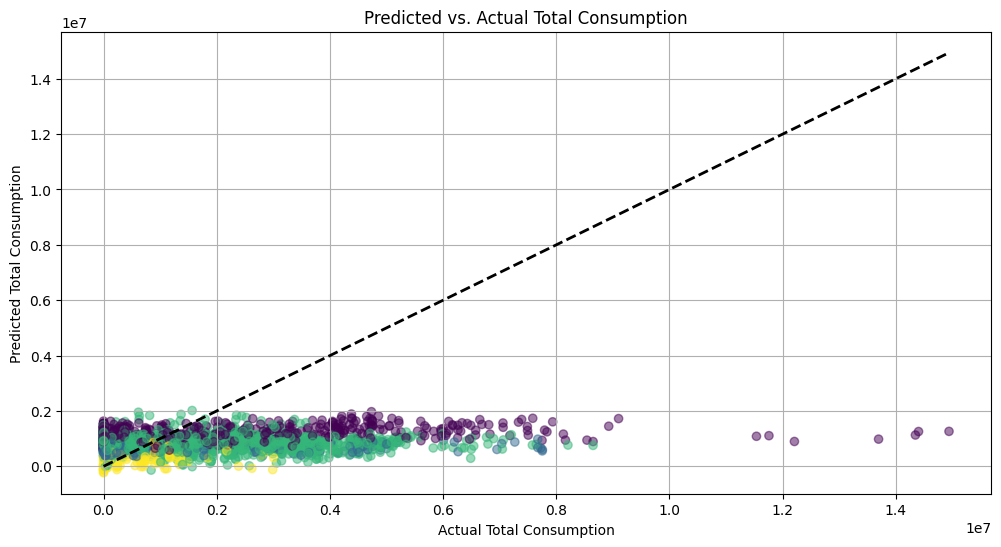

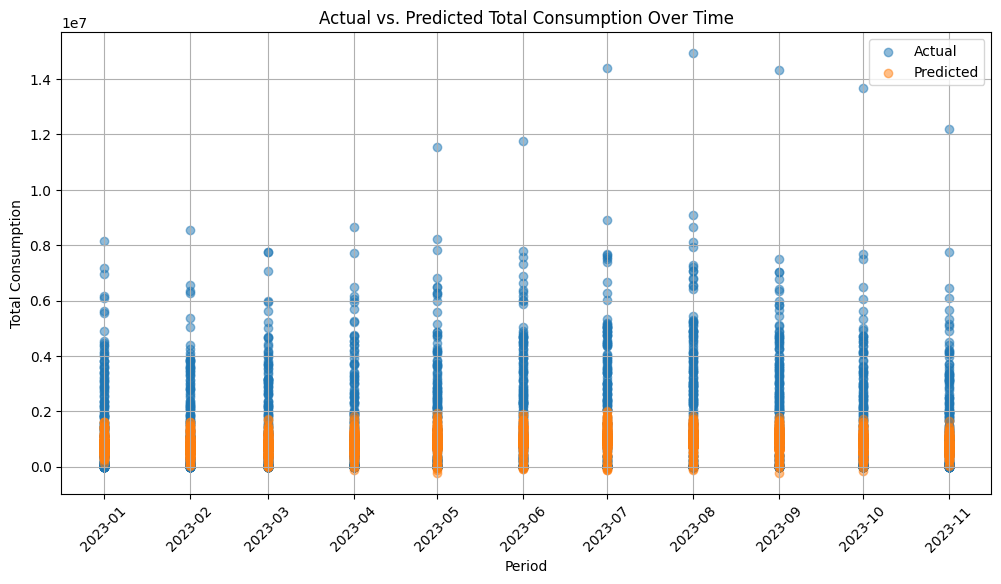

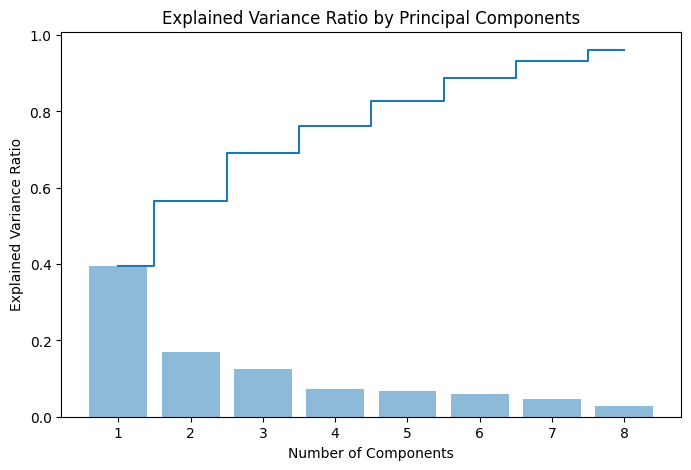

Number of components to retain: 8

Top features for PC1: TEMP, TEMPEXT_BASE40, TEMPEXT_BASE45

Top features for PC2: MXSPD, WDSP, GUST

Top features for PC3: LONGITUDE, LATITUDE, Zip

Top features for PC4: PRCP, plantCode, ELEVATION

Top features for PC5: PRCP, SNDP, plantCode

Top features for PC6: SNDP, plantCode, PRCP

Top features for PC7: ELEVATION, plantCode, WDSP

Top features for PC8: GUST, ELEVATION, PRCP


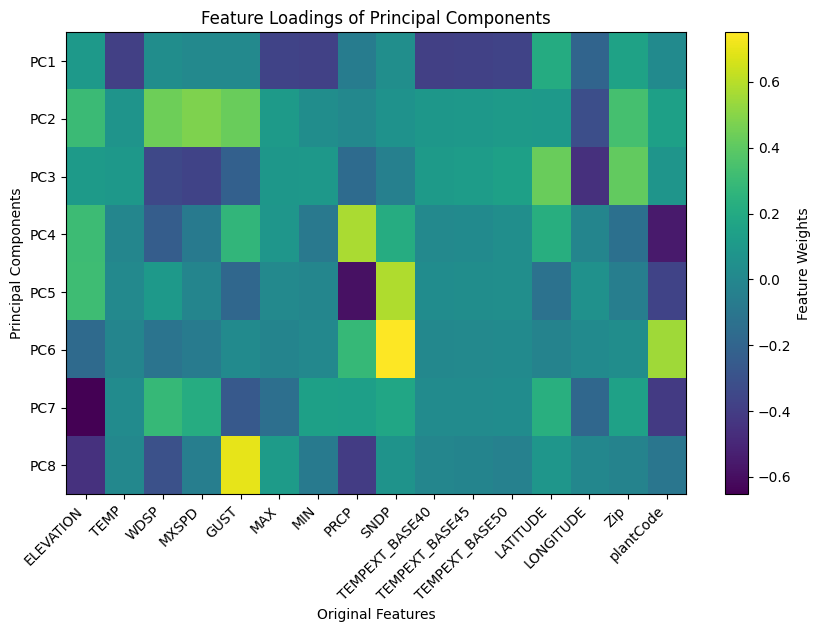

In [19]:
## Linear Regression first!
model = LinearRegression()

# Call the function with the model and other parameters
train_test_and_plot(data, model, start_train, end_train, start_test, end_test, model_features)

Number of unique power plants per state:
FL: 88
MI: 89
TX: 303
WA: 23
Model evaluation:
Mean Squared Error: 489510717757.224
R-squared: 0.8729443215639714


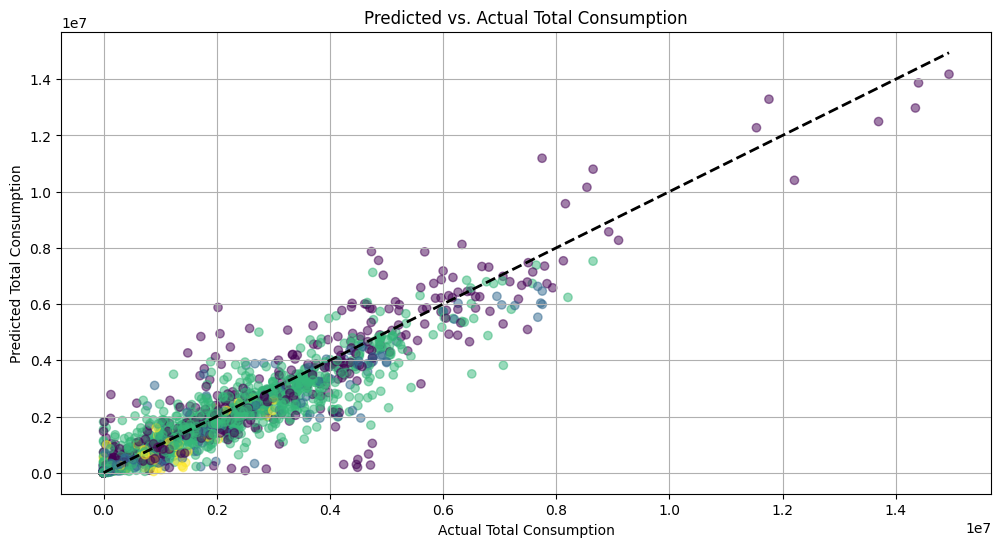

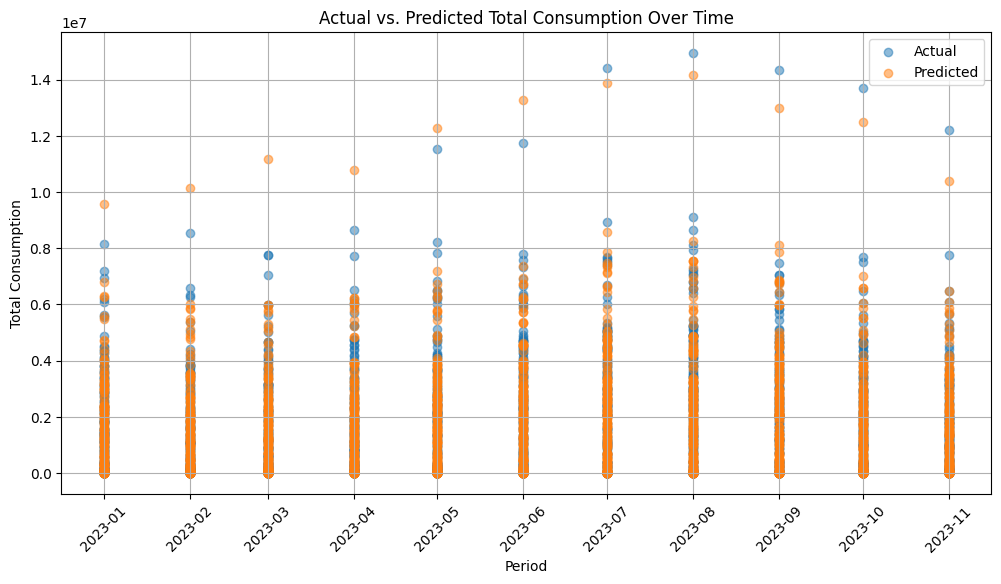

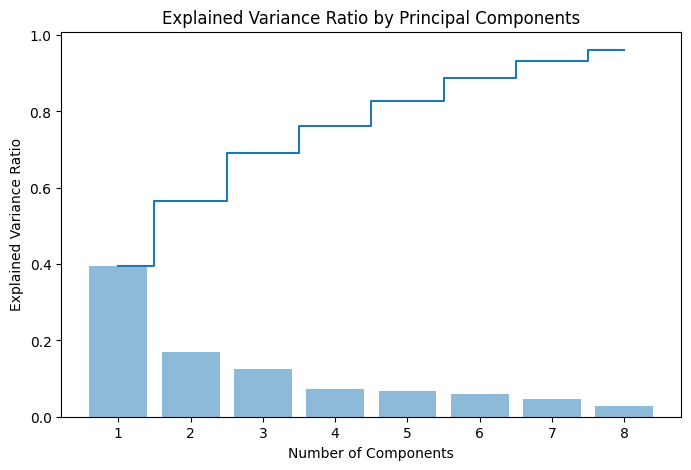

Number of components to retain: 8

Top features for PC1: TEMP, TEMPEXT_BASE40, TEMPEXT_BASE45

Top features for PC2: MXSPD, WDSP, GUST

Top features for PC3: LONGITUDE, LATITUDE, Zip

Top features for PC4: PRCP, plantCode, ELEVATION

Top features for PC5: PRCP, SNDP, plantCode

Top features for PC6: SNDP, plantCode, PRCP

Top features for PC7: ELEVATION, plantCode, WDSP

Top features for PC8: GUST, ELEVATION, PRCP


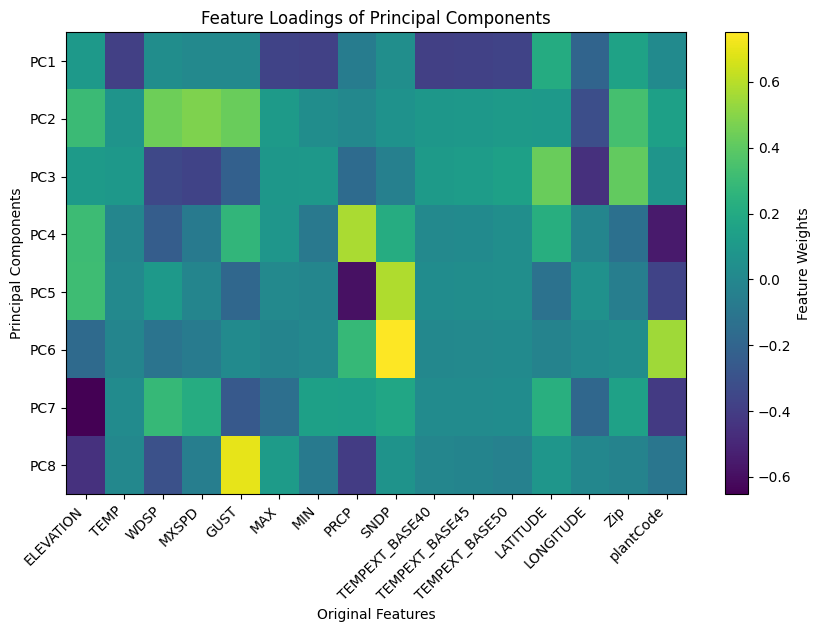

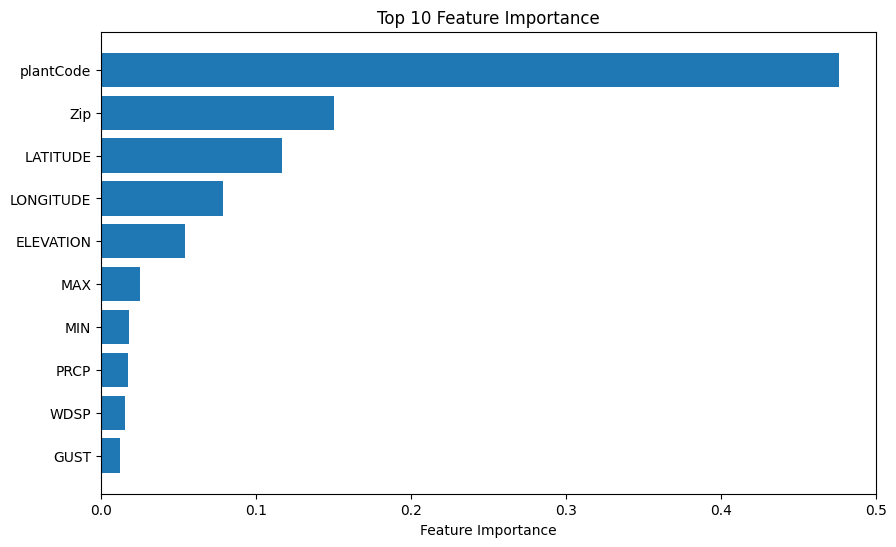

In [20]:
# Define the number of trees in the forest
n_estimators = 100  # Example number of trees, you can change it as needed

# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=n_estimators)

# Call the function with the model and other parameters
train_test_and_plot(data, rf_model, start_train, end_train, start_test, end_test, model_features)

Number of unique power plants per state:
FL: 88
MI: 89
TX: 303
WA: 23
Model evaluation:
Mean Squared Error: 493910875597.5931
R-squared: 0.8718022320869623


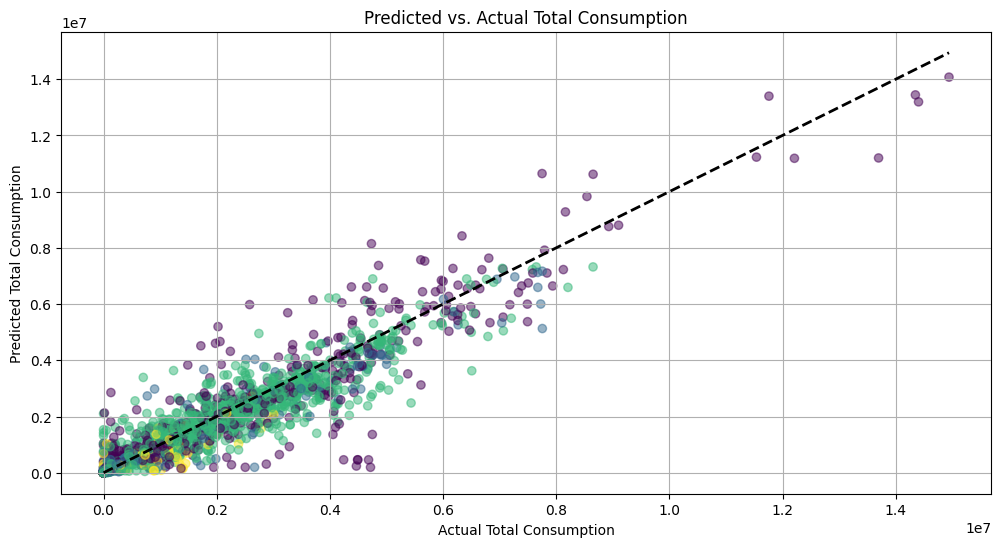

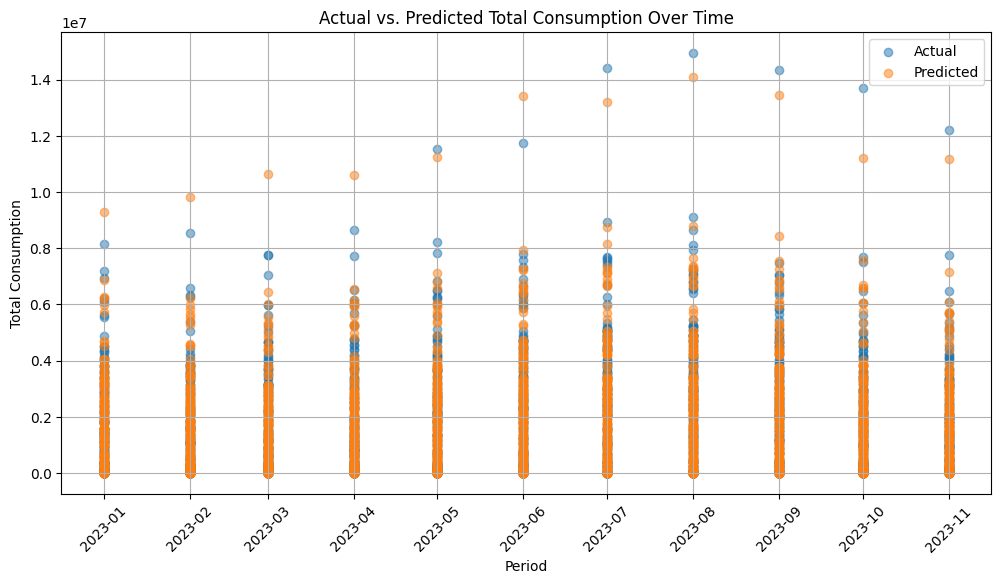

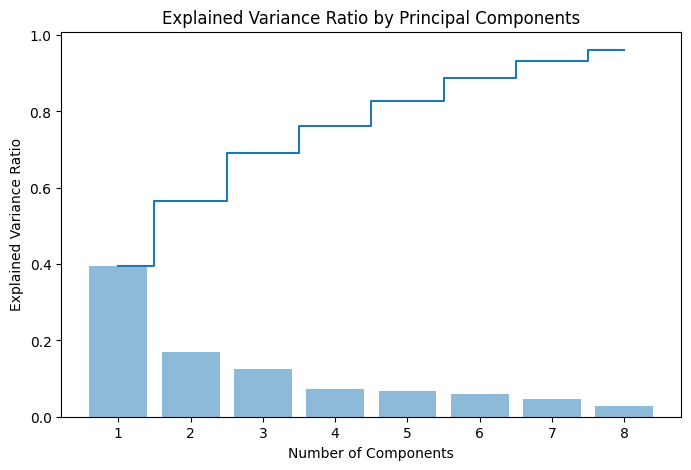

Number of components to retain: 8

Top features for PC1: TEMP, TEMPEXT_BASE40, TEMPEXT_BASE45

Top features for PC2: MXSPD, WDSP, GUST

Top features for PC3: LONGITUDE, LATITUDE, Zip

Top features for PC4: PRCP, plantCode, ELEVATION

Top features for PC5: PRCP, SNDP, plantCode

Top features for PC6: SNDP, plantCode, PRCP

Top features for PC7: ELEVATION, plantCode, WDSP

Top features for PC8: GUST, ELEVATION, PRCP


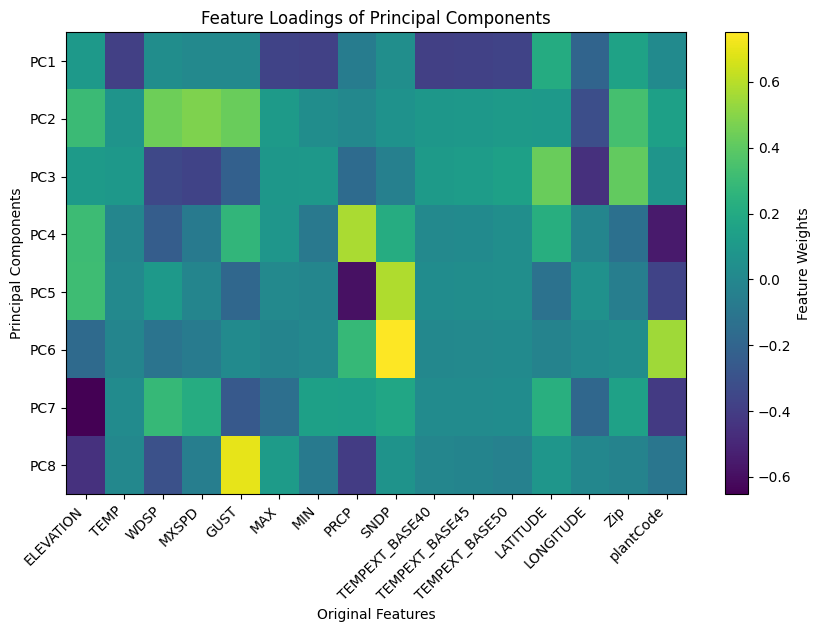

In [21]:
knn_model = KNeighborsRegressor(n_neighbors=5)

# Call the train_test_and_plot function
train_test_and_plot(data, knn_model, start_train, end_train, start_test, end_test, model_features)


Number of unique power plants per state:
FL: 88
MI: 89
TX: 303
WA: 23
Model evaluation:
Mean Squared Error: 964347168175.8802
R-squared: 0.74969744429331


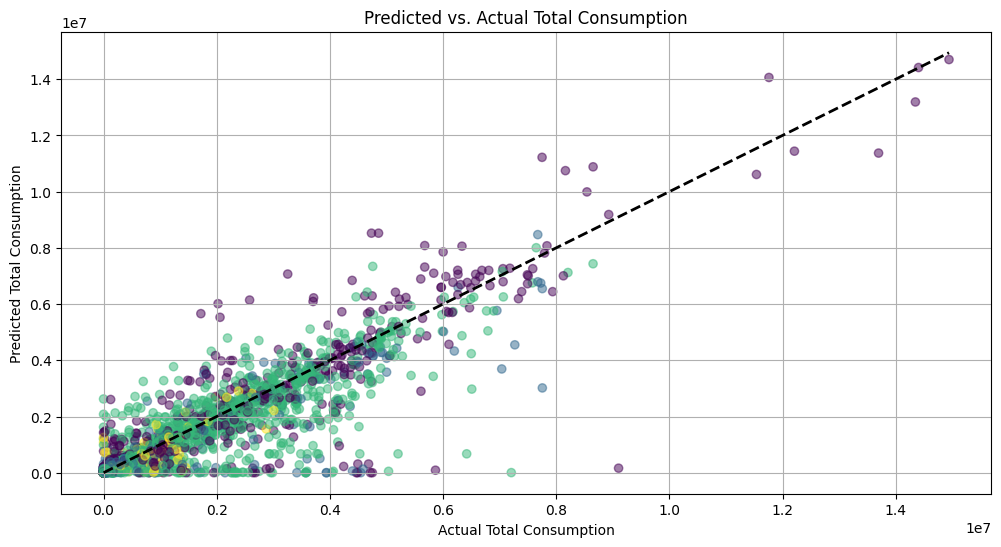

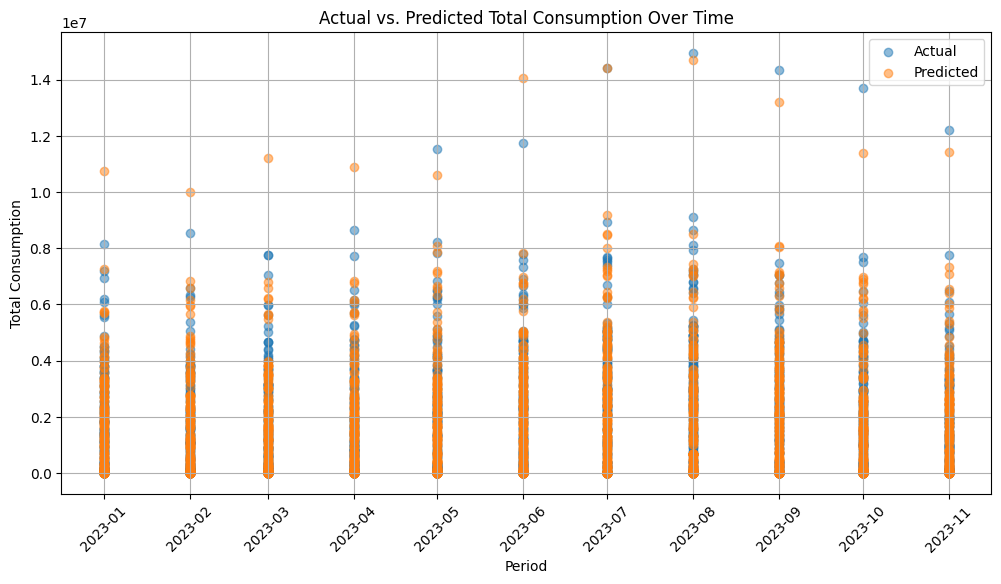

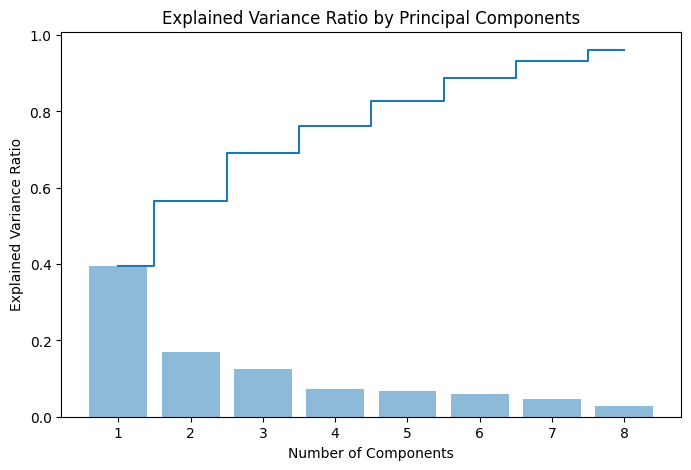

Number of components to retain: 8

Top features for PC1: TEMP, TEMPEXT_BASE40, TEMPEXT_BASE45

Top features for PC2: MXSPD, WDSP, GUST

Top features for PC3: LONGITUDE, LATITUDE, Zip

Top features for PC4: PRCP, plantCode, ELEVATION

Top features for PC5: PRCP, SNDP, plantCode

Top features for PC6: SNDP, plantCode, PRCP

Top features for PC7: ELEVATION, plantCode, WDSP

Top features for PC8: GUST, ELEVATION, PRCP


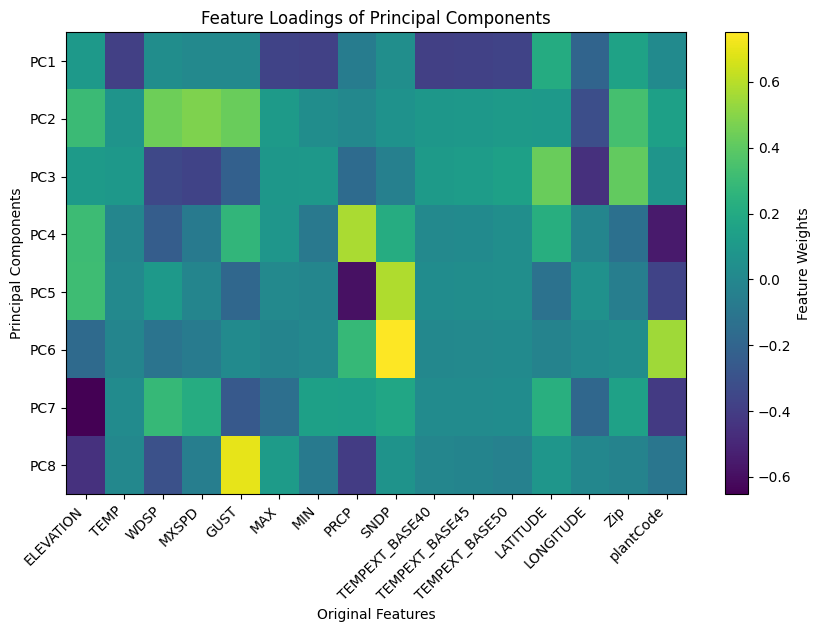

In [22]:
nb_model = GaussianNB()
train_test_and_plot(data, nb_model, start_train, end_train, start_test, end_test, model_features)


In [ ]:
## Add feature importance score in place of PCA